## Cost of living - items 

### Read data into convenient form
* Delete columns without meaningful information
* Rename columns properly
* All cells are prices - change type to float
* Merge different years data 

In [1]:
import os
from pandas import concat as pd_concat
from pandas import to_numeric
from pandas import read_csv


# years = [str(year) for year in range(2010, 2021)]
# results_by_year = dict(zip(years, [[] for i in range(len(years))]))

results_by_item = {}
code_mapping = {}

directory = "web_scraper/every_item_by_country_in_usd"
    
for file in os.listdir(directory):
    file_path = directory + '/' + file
    if file_path.endswith('.csv'):
        item_code = file[13:file.index('.')]
        if item_code in results_by_item:
            results_by_item[item_code].append(read_csv(file_path))
        else:
            results_by_item[item_code] = [read_csv(file_path)]
            code_mapping[item_code] = results_by_item[item_code][-1].columns[3]
        results_by_item[item_code][-1].drop(['Unnamed: 0', 'Rank'], axis=1, inplace=True)
        results_by_item[item_code][-1].rename(columns={results_by_item[item_code][-1].columns[1]: file[8:12]}, inplace = True)
        results_by_item[item_code][-1].rename(columns={'City': 'Country'}, inplace = True)
        results_by_item[item_code][-1].set_index('Country', inplace=True)
        results_by_item[item_code][-1] = results_by_item[item_code][-1].apply(lambda x: to_numeric(x, errors='coerce'))

for key in results_by_item:
    results_by_item[key] = pd_concat(results_by_item[key], axis=1, join='outer')
    results_by_item[key] = results_by_item[key].loc[:,~results_by_item[key].columns.duplicated()]

results_by_item['1']

,2012,2014,2017,2019,2011,2010,2016,2013,2015,2018,2020
Albania,4.25,6.33,5.64,4.56,NaN,NaN,4.92,NaN,6.20,5.11,4.92
Argentina,9.65,10.00,10.68,7.38,8.62,7.25,10.89,10.01,12.00,10.02,6.79
Australia,16.94,15.74,12.79,13.88,18.62,12.71,13.41,15.38,13.69,14.34,13.45
Austria,9.88,10.89,11.20,12.31,10.87,13.58,11.35,10.39,9.84,13.43,11.41
Bahrain,5.41,5.31,6.63,6.63,NaN,NaN,5.31,5.41,5.31,5.29,7.97
...,...,...,...,...,...,...,...,...,...,...,...
Ghana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.38,NaN,4.25,4.31
Bahamas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00,NaN
Belize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fiji,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.85,NaN


### Drop rows with incomplete inormation (with any NaN)

In [2]:
for key in results_by_item:
    for index, row in results_by_item[key].iterrows():
        if row.isnull().sum() > 0:
            results_by_item[key].drop(index, inplace=True)

In [3]:
results_by_item['1'].pct_change(axis='columns').max().max()

0.9196617336152217

In [4]:
print(code_mapping)

{'30': 'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment', '106': 'Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate', '42': 'Tennis Court Rent (1 Hour on Weekend)', '19': 'Chicken Fillets (1kg)', '27': 'Apartment (1 bedroom) Outside of Centre', '40': 'Fitness Club, Monthly Fee for 1 Adult', '107': 'Taxi Start (Normal Tariff)', '115': 'Rice (white), (1kg)', '17': 'Cigarettes 20 Pack (Marlboro)', '29': 'Apartment (3 bedrooms) Outside of Centre', '11': 'Eggs (regular) (12)', '118': 'Banana (1kg)', '206': 'Toyota Corolla Sedan 1.6l 97kW Comfort (Or Equivalent New Car)', '3': 'McMeal at McDonalds (or Equivalent Combo Meal)', '12': 'Local Cheese (1kg)', '32': '1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans)', '6': 'Coke/Pepsi (0.33 liter bottle)', '60': '1 Pair of Jeans (Levis 501 Or Similar)', '44': 'Cinema, International Release, 1 Seat', '101': 'Price per Square Meter to Buy Apartment Outside of Centre', '24': 'Gasoline (1 li

### Check maximum annual changes in products prices
* Now we have ~30 different products prices in 10 years for ~60 different countries
* Analysing so much data is very difficult even on some charts
* We assume that if price of product have not changed over year or if was doubled,  tripled etc there is nothing 'suspicious' in our data
* If we see that price of any product have risen dramatically we can analyse this data further

In [5]:
import numpy as np

for key in results_by_item:
    max_val = results_by_item[key].pct_change(axis='columns').max().max()
    if not np.isnan(max_val):
        print(code_mapping[key])
        print('    ', max_val)

Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment
     2.941321044546851
Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate
     1.996197718631179
Tennis Court Rent (1 Hour on Weekend)
     9.387811634349031
Chicken Fillets (1kg)
     3.533333333333333
Apartment (1 bedroom) Outside of Centre
     2.1997005068345876
Fitness Club, Monthly Fee for 1 Adult
     3.7012927054478304
Cigarettes 20 Pack (Marlboro)
     5.0
Apartment (3 bedrooms) Outside of Centre
     2.9725144943096415
Eggs (regular) (12)
     0.7818181818181817
McMeal at McDonalds (or Equivalent Combo Meal)
     0.6428571428571428
Local Cheese (1kg)
     1.82295719844358
1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans)
     3.2272727272727275
Coke/Pepsi (0.33 liter bottle)
     1.4390243902439024
1 Pair of Jeans (Levis 501 Or Similar)
     18.73
Cinema, International Release, 1 Seat
     1.019073569482289
Price per Square Meter to Buy Apartment Outside of Centre
    

In [6]:
results_by_item['60'].pct_change(axis='columns').max(axis=0)
results_by_item['60'].pct_change(axis='columns').max(axis=1)

Argentina                  0.862551
Australia                  0.355711
Austria                    0.294266
Belgium                    0.130523
Bosnia And Herzegovina     0.686214
                            ...    
Turkey                     0.494153
United Arab Emirates       1.235469
United Kingdom             0.243472
United States              0.130412
Vietnam                   18.730000
Length: 62, dtype: float64

### Changes in prices are reasonable, price of Levis jeans in Vietnam is interesting...

### Cost of living

### Clear cos of living data from null values

In [7]:
from pandas import read_csv
filename = f'./dataset/cost_of_living/cost_of_living.csv'
df = read_csv(filename)

In [8]:
import numpy as np
for index, row in df.iterrows():
    #print(index, row.isnull().sum(), np.isnan(row['2010']), row['2020'])
    if row.isnull().sum() > 1 or np.isnan(row['2010']) or np.isnan(row['2020']):
        #print(index)
        df.drop(index, inplace=True)

df

,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2,Argentina,1287.8540,1567.5980,1938.3650,1855.1085,2003.9330,2250.2455,2134.153345,2162.854675,1845.922275,1547.585985,1450.537395
4,Australia,2305.9525,3402.0115,3497.3400,3606.2805,3505.2375,3031.5370,3015.473135,3013.260195,3118.820875,3015.915325,3029.782315
5,Austria,2098.4985,2771.5665,2395.3730,2461.0660,2535.7345,2414.0015,2746.560665,2763.594395,2892.079440,2807.800890,2715.892825
11,Belgium,2467.6735,3089.2735,2618.6360,2795.8555,3031.6935,2755.3645,2950.407795,2784.550510,3012.334075,2876.052530,2974.076965
14,Bosnia And Herzegovina,1201.1620,1351.2165,1291.5925,1345.5085,1383.9850,1215.0130,1374.416230,1362.515830,1452.223765,1488.702065,1454.164550
...,...,...,...,...,...,...,...,...,...,...,...,...
110,Ukraine,1001.6765,1253.1840,1256.3955,1329.7065,1014.9345,947.9125,936.425885,998.245440,1142.973940,1198.745980,1233.190635
111,United Arab Emirates,1752.0950,2135.5455,2042.7365,1978.7495,2117.8465,2336.8500,2442.872225,2506.675330,2296.174310,2498.397065,2517.766505
112,United Kingdom,1957.8065,2791.6110,2738.7450,2710.7320,3020.5150,3067.3230,3004.957595,2656.633670,2781.695775,2659.461150,2715.243565
113,United States,1746.0775,2119.8475,2244.9175,2293.0675,2348.5135,2689.5460,2751.786190,2780.979080,2826.855595,2849.910670,2975.528000


### For one null in vector we can calculate average for this point based on neighbours..

In [9]:
df[~df[[str(x) for x in range(2010, 2021)]].notnull().all(1)]

,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
56,Kazakhstan,1147.81,NaN,1843.978,1945.0405,1603.366,1745.6235,1205.16101,1398.811065,1371.326305,1231.30863,1281.961635
82,Panama,1073.08,1404.631,NaN,1556.5125,1649.140,1750.0215,2108.12050,1903.665235,2085.353280,2164.04550,2264.674500


In [10]:
df.at[56, '2011'] = (df.at[56, '2010']+df.at[56, '2012'])/2
df.at[82, '2012'] = (df.at[82, '2011']+df.at[82, '2013'])/2
df.at[82, '2012']

1480.57175

In [11]:
df[~df[[str(x) for x in range(2010, 2021)]].notnull().all(1)]

,Country,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020


### Plot cost of living

In [12]:
df_plt = df

In [13]:
df_plt.set_index('Country')

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,
Argentina,1287.8540,1567.5980,1938.3650,1855.1085,2003.9330,2250.2455,2134.153345,2162.854675,1845.922275,1547.585985,1450.537395
Australia,2305.9525,3402.0115,3497.3400,3606.2805,3505.2375,3031.5370,3015.473135,3013.260195,3118.820875,3015.915325,3029.782315
Austria,2098.4985,2771.5665,2395.3730,2461.0660,2535.7345,2414.0015,2746.560665,2763.594395,2892.079440,2807.800890,2715.892825
Belgium,2467.6735,3089.2735,2618.6360,2795.8555,3031.6935,2755.3645,2950.407795,2784.550510,3012.334075,2876.052530,2974.076965
Bosnia And Herzegovina,1201.1620,1351.2165,1291.5925,1345.5085,1383.9850,1215.0130,1374.416230,1362.515830,1452.223765,1488.702065,1454.164550
...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,1001.6765,1253.1840,1256.3955,1329.7065,1014.9345,947.9125,936.425885,998.245440,1142.973940,1198.745980,1233.190635
United Arab Emirates,1752.0950,2135.5455,2042.7365,1978.7495,2117.8465,2336.8500,2442.872225,2506.675330,2296.174310,2498.397065,2517.766505
United Kingdom,1957.8065,2791.6110,2738.7450,2710.7320,3020.5150,3067.3230,3004.957595,2656.633670,2781.695775,2659.461150,2715.243565


In [14]:
df_plt = df_plt.set_index('Country')
df_plt

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,
Argentina,1287.8540,1567.5980,1938.3650,1855.1085,2003.9330,2250.2455,2134.153345,2162.854675,1845.922275,1547.585985,1450.537395
Australia,2305.9525,3402.0115,3497.3400,3606.2805,3505.2375,3031.5370,3015.473135,3013.260195,3118.820875,3015.915325,3029.782315
Austria,2098.4985,2771.5665,2395.3730,2461.0660,2535.7345,2414.0015,2746.560665,2763.594395,2892.079440,2807.800890,2715.892825
Belgium,2467.6735,3089.2735,2618.6360,2795.8555,3031.6935,2755.3645,2950.407795,2784.550510,3012.334075,2876.052530,2974.076965
Bosnia And Herzegovina,1201.1620,1351.2165,1291.5925,1345.5085,1383.9850,1215.0130,1374.416230,1362.515830,1452.223765,1488.702065,1454.164550
...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,1001.6765,1253.1840,1256.3955,1329.7065,1014.9345,947.9125,936.425885,998.245440,1142.973940,1198.745980,1233.190635
United Arab Emirates,1752.0950,2135.5455,2042.7365,1978.7495,2117.8465,2336.8500,2442.872225,2506.675330,2296.174310,2498.397065,2517.766505
United Kingdom,1957.8065,2791.6110,2738.7450,2710.7320,3020.5150,3067.3230,3004.957595,2656.633670,2781.695775,2659.461150,2715.243565


### This shape of plot is expected (a rise after crisis, countries hierarchy)

<AxesSubplot:>

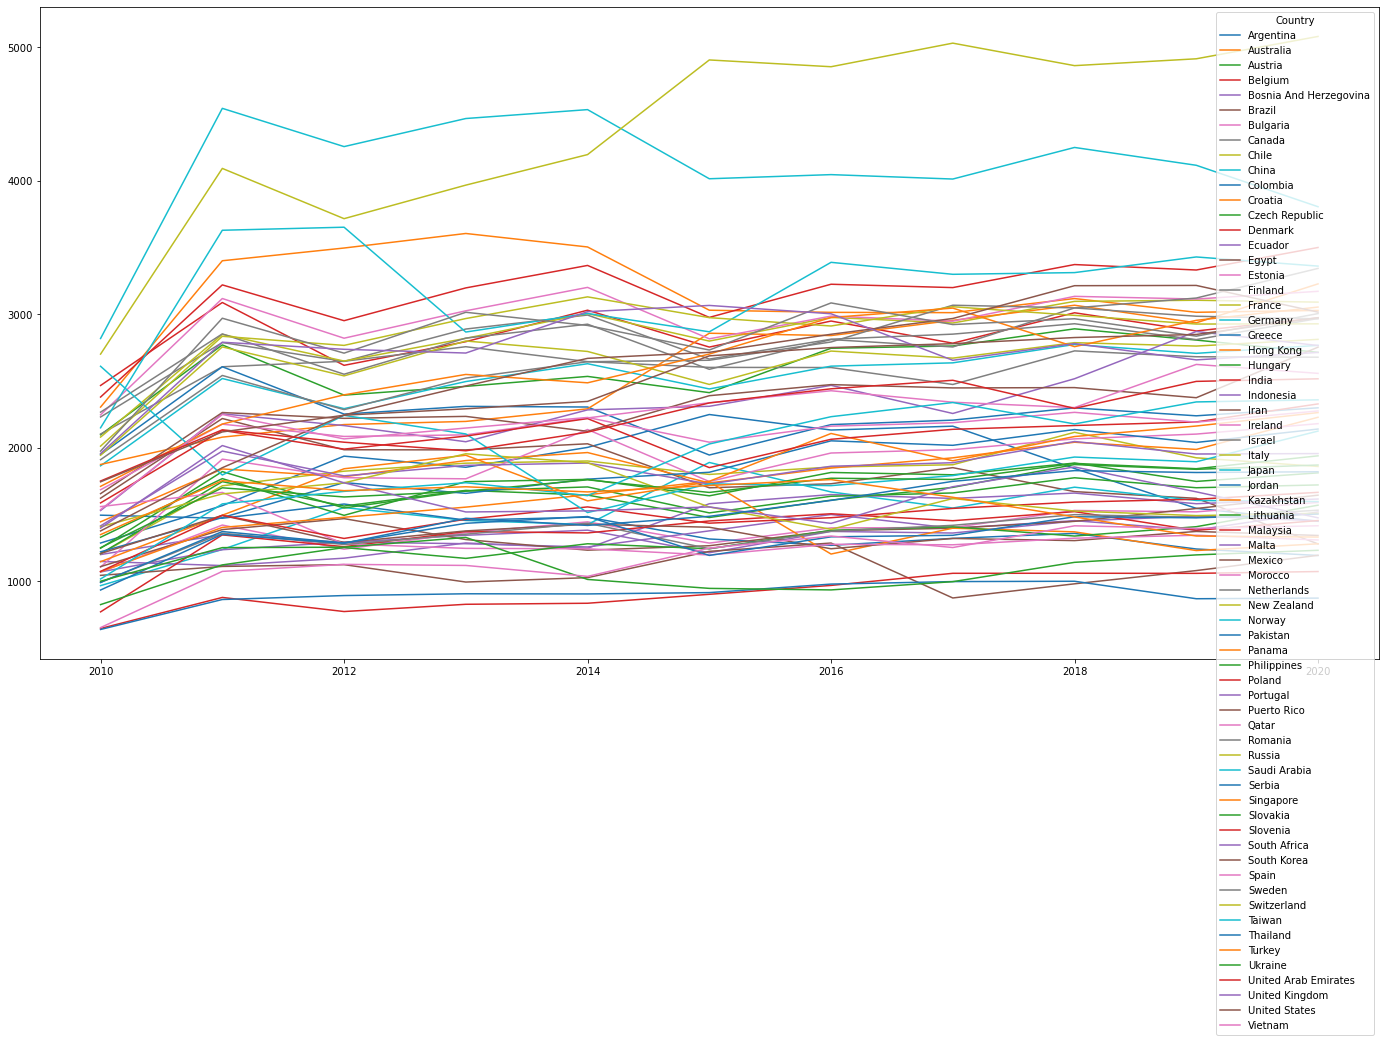

In [15]:
df_plt.T.plot(figsize=(24,12))

### This shape of plot is expected, no assumptions for invalid data 

<AxesSubplot:>

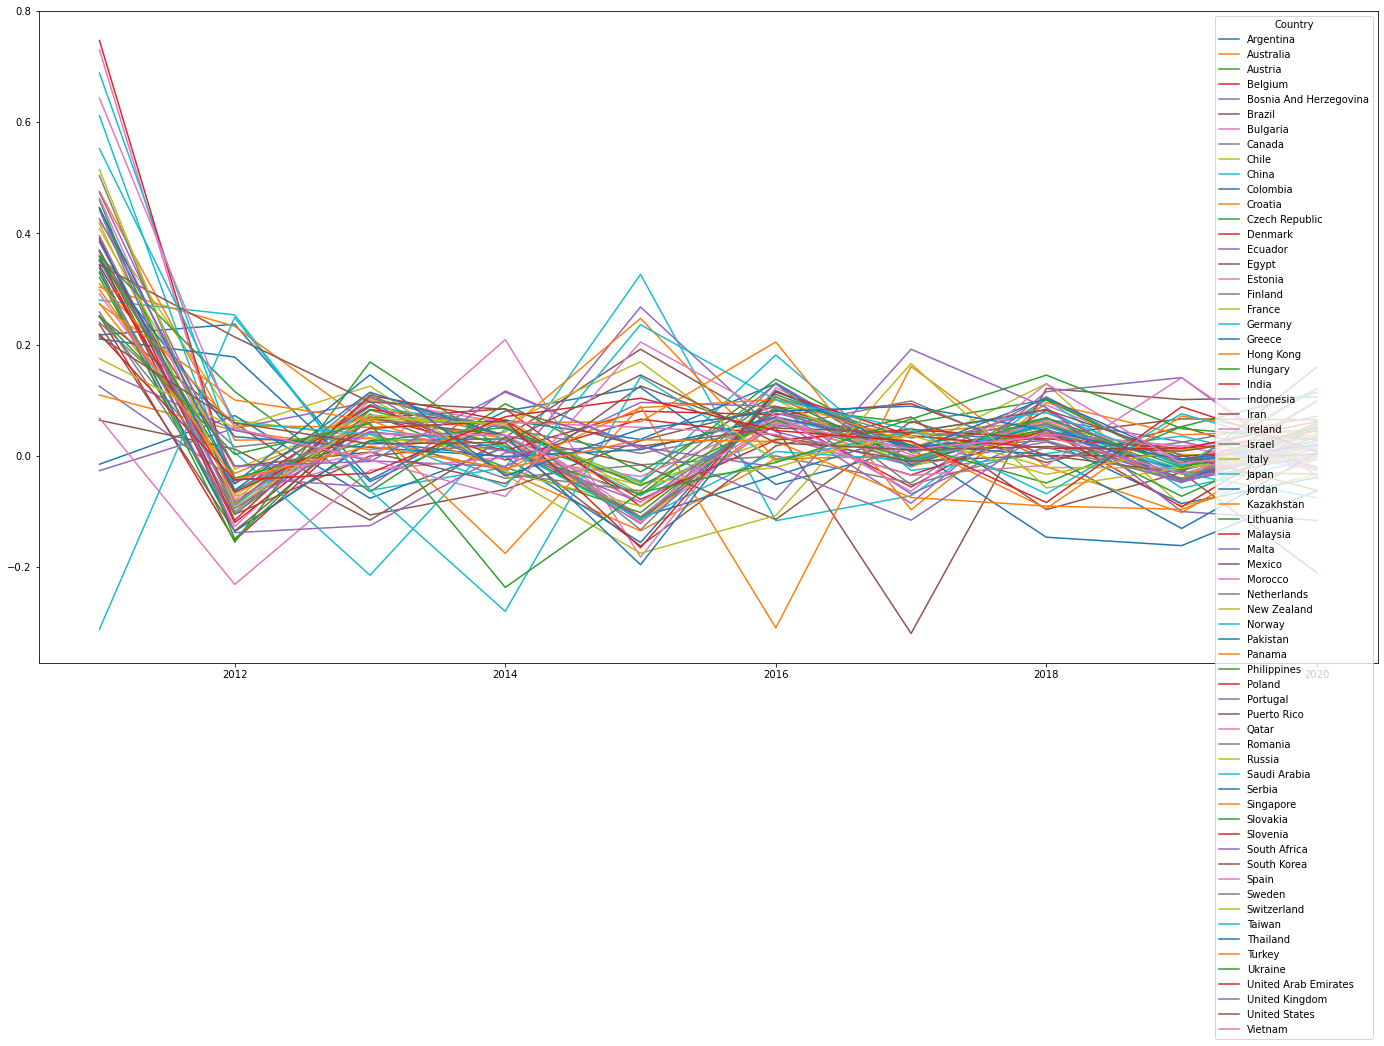

In [16]:
df_plt.pct_change(axis='columns').T.plot(figsize=(24,12))

In [18]:
filename = f'./dataset/cost_of_living.csv'
with open(filename, 'w') as file:
    # BE SURE YOU WANT TO OVERWRITE
    df.to_csv(file, index=False, line_terminator='\n')